# Tutorial 5: Recurrent Neural Networks with Pytorch (Long Short-Term Memory (LSTM) Networks)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler

The data has two columns, the month and the number of passengers. Since the data are arranged in chronological order, you can take only the number of passenger to make a single-feature time series. Below you will use pandas library to read the CSV file and convert it into a 2D numpy array, then plot it using matplotlib:

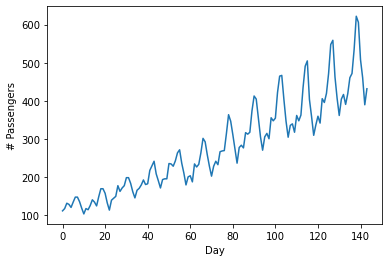

In [65]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
timeseries = dataset.astype('float32')
plt.plot(timeseries)
plt.xlabel('Day')
plt.ylabel('# Passengers')
plt.show()

This time series has 144 time steps. You can see from the plot that there is an upward trend. There are also some periodicity in the dataset that corresponds to the summer holiday period in the northern hemisphere. 

To demonstrate the predictive power of our model, the time series is splitted into training and test sets. Unlike other dataset, usually time series data are splitted without shuffling. That is, the training set is the first half of time series and the remaining will be used as the test set. This can be easily done on a numpy array:

In [66]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [67]:
print(train.shape, test.shape)

(97, 1) (49, 1)


The more complicated problem is how do you want the network to predict the time series. Usually time series prediction is done on a window. That is, given data from time t - w to time t, you are asked to predict for time t+1  (or deeper into the future). The size of window governs how much data you are allowed to look at when you make the prediction. This is also called the look back period.

In [68]:
# a function to generate a dataset of fixed window from a time series. 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback-2):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [69]:
# generate features and labels for the training and testing datasets

lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
y_train, y_test = y_train[:, -1, :], y_test[:, -1, :]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([92, 3, 1]) torch.Size([92, 1])
torch.Size([44, 3, 1]) torch.Size([44, 1])


The LSTM layer is created with option batch_first=True because the tensors you prepared is in the dimension of (window sample, time steps, features) and where a batch is created by sampling on the first dimension.

In [70]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        # Since we are going to predict t+1, 
        # we extract only the last time step from the model output as prediction.
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [71]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.9452, test RMSE 427.9866
Epoch 100: train RMSE 183.3130, test RMSE 382.2953
Epoch 200: train RMSE 149.9936, test RMSE 346.3048
Epoch 300: train RMSE 120.1875, test RMSE 312.2255
Epoch 400: train RMSE 96.4823, test RMSE 281.9991
Epoch 500: train RMSE 70.9546, test RMSE 245.3072
Epoch 600: train RMSE 54.2480, test RMSE 216.1021
Epoch 700: train RMSE 42.5607, test RMSE 190.9730
Epoch 800: train RMSE 34.9062, test RMSE 169.7047
Epoch 900: train RMSE 30.1798, test RMSE 152.1241
Epoch 1000: train RMSE 27.2686, test RMSE 137.8721
Epoch 1100: train RMSE 25.1887, test RMSE 126.4934
Epoch 1200: train RMSE 24.0067, test RMSE 117.5584
Epoch 1300: train RMSE 23.3227, test RMSE 110.8299
Epoch 1400: train RMSE 22.5353, test RMSE 105.7245
Epoch 1500: train RMSE 22.1572, test RMSE 102.6245
Epoch 1600: train RMSE 21.4360, test RMSE 100.1701
Epoch 1700: train RMSE 20.7982, test RMSE 95.1382
Epoch 1800: train RMSE 20.5828, test RMSE 92.4328
Epoch 1900: train RMSE 20.3630, test RMSE

The training set is plotted in red while the test set is plotted in green. The blue curve is what the actual data looks like. You can see that the model can fit well to the training set but not very well on the test set.

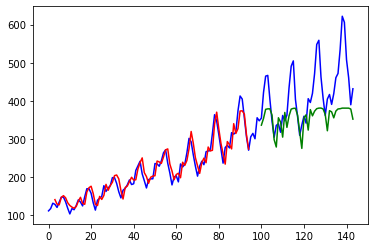

In [72]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
#     y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size - 2] = model(X_train)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback: len(timeseries)-2] = model(X_test)
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()